In [1]:
from general_framework import *

# This framework is for recalling (reconstructing) images from between 1 and N elements ago
# The first 3 are probably stored in canvases (and that will be the first version); the others
# will require difficult reconstruction from memory.
#
# This is focused only on images for now. Text recollection may come, later.
# RAW. Needs calibration; may or may not work. THe 'context' tensor may need better markers for what comes from which input

N_lookback = 3 # just canvases for now
min_lookback = 0 

current_image_prompts = [\
    "Hey, recall the current image again?", \
    "Focus on the present view, please.", \
    "What do you see right now?", \
    "Think about the present game, for a moment."\
]

prev_image_prompts = [\
    "Hey, recall the last image, again?", \
    "Focus on the last view, please.", \
    "What did you see 1 image ago?", \
    "Think about the last game, for a moment.", \
    "Woah! What was that 1 image ago, again???" \
]

def get_image_prompts(ind):
    return [\
        f"Hey, could you recall the image {ind} ago, again?", \
        f"Focus on the view {ind} ago, please.", \
        f"Hey, recall the game {ind} ago for me, will you?", \
        f"Woah! What was that {ind} images ago, again??", \
        f"Think about the game from {ind} ago for me, will you?", \
        f"What did you see {ind} games ago, again.", \
        f"Think about the view {ind} steps ago, for a moment." \
    ]   

lookback_prompts = [current_image_prompts, prev_image_prompts]

for n in range(2, N_lookback):
    lookback_prompts.append(get_image_prompts(n))

lookback_prompts = lookback_prompts[min_lookback:N_lookback]

def mem_task_img_sample(num_sample=40):
    img_in = torch.zeros(num_sample, 224, 224, 3)
    for i in range(num_sample):
        bare_settings = G.random_bare_settings(gameSize=224, max_agent_offset=0.5)
        G2 = discreteGame(bare_settings)
        img_in[i] = torch.tensor(G2.getData())
    img_in = torch.permute(img_in, (0, 3, 1, 2)).contiguous().to(device)
    return img_in


pygame 2.6.1 (SDL 2.28.4, Python 3.12.8)
Hello from the pygame community. https://www.pygame.org/contribute.html
🔥 text_pretraining_data/eng_sentences_pruned-train.txt
🔥 text_pretraining_data/eng_sentences_pruned-eval.txt


In [2]:
# newest to oldest, possible targets
def get_prompts(img_tensor_list):
    batch_size = img_tensor_list[0].size()[0]
    lookback_vals = np.random.randint(0, N_lookback - min_lookback, (batch_size,))

    target = torch.zeros_like(img_tensor_list[0])
    prompts = []

    for ind in range(batch_size):
        lookback = lookback_vals[ind]
        target[ind] = img_tensor_list[lookback][ind].detach()
        prompts.append(random.choice(lookback_prompts[lookback + min_lookback]))

    target = target.contiguous()

    prompt_tensor = torch.tensor([x.ids for x in tokenizer.encode_batch(prompts)]).contiguous().to(device)
    padded_prompt_tensor = torch.zeros((batch_size, 32), dtype=prompt_tensor.dtype, device=prompt_tensor.device)
    padded_prompt_tensor[:, :prompt_tensor.size()[1]] += prompt_tensor
    return padded_prompt_tensor, target



In [3]:
from visual_transformer import *
from visual_transformer.enhanced_model import *

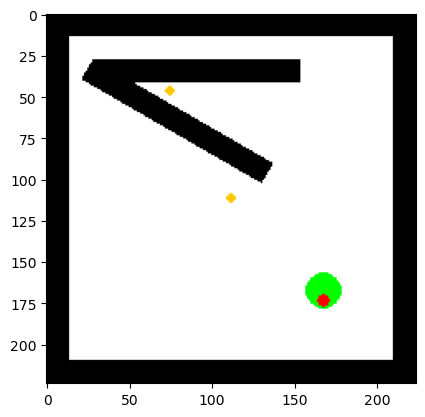

In [4]:
import matplotlib.pyplot as plt
plt.imshow(G.getData())

In [5]:
def quick_display(torch_img):
    clean = torch_img.detach().cpu()
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy()
    plt.imshow(array)

In [6]:
batch_size = 8
batch_num = 12 # why not?

In [9]:
lookback_prompts[2]

['Hey, could you recall the image 2 ago, again?',
 'Focus on the view 2 ago, please.',
 'Hey, recall the game 2 ago for me, will you?',
 'Woah! What was that 2 images ago, again??',
 'Think about the game from 2 ago for me, will you?',
 'What did you see 2 games ago, again.',
 'Think about the view 2 steps ago, for a moment.']

In [10]:
ind = (batch_num * batch_size) % num_controls
if ind + batch_size > num_controls:
    ind = num_controls - batch_size
control_texts = sdt[ind:ind + batch_size].to(device)

In [11]:
tokenizer.decode(control_texts[0].detach().cpu().numpy())

'<s>You are saying you intentionally hide your good looks?</s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>'

In [12]:
# perfect

In [16]:
def quick_str(text_tensor):
    if len(text_tensor.size()) > 1:
        text_tensor = text_tensor[0]
    return tokenizer.decode(text_tensor.detach().cpu().numpy())

In [13]:
img_tensor_list = []
prompt_tensor_list = []

In [14]:
for step in range(N_lookback):
    imgs = mem_task_img_sample(batch_size)
    img_tensor_list.append(imgs)
    if step == N_lookback - 1:
        L = img_tensor_list[min_lookback:]
        L.reverse() # img_tensor_list should be unharmed by this
        prompt_tensor, target = get_prompts(L)
        prompt_tensor_list.append(prompt_tensor)
    else:
        prompt_tensor_list.append(control_texts)

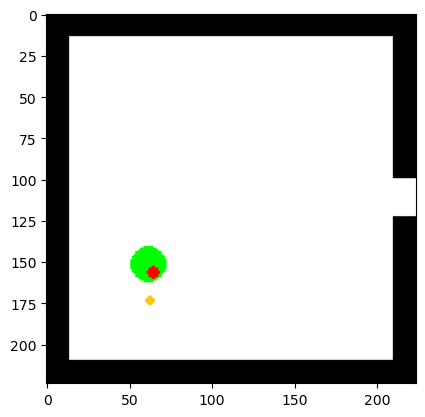

In [40]:
quick_display(img_tensor_list[0][5])

In [41]:
quick_str(prompt_tensor_list[0][5])

'<s>This is not important.</s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>'

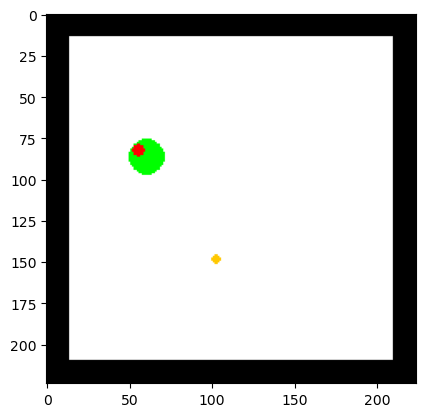

In [42]:
quick_display(img_tensor_list[1][5])

In [43]:
quick_str(prompt_tensor_list[1][5])

'<s>This is not important.</s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>'

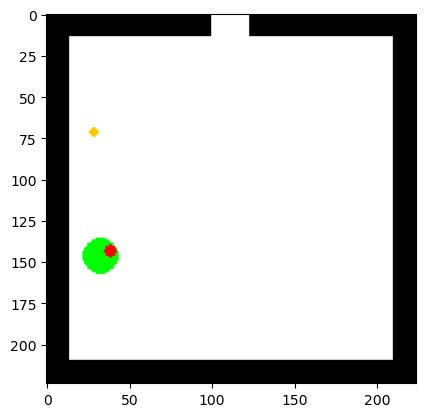

In [44]:
quick_display(img_tensor_list[2][5])

In [45]:
quick_str(prompt_tensor_list[2][5])

'<s>What do you see right now?</s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>'

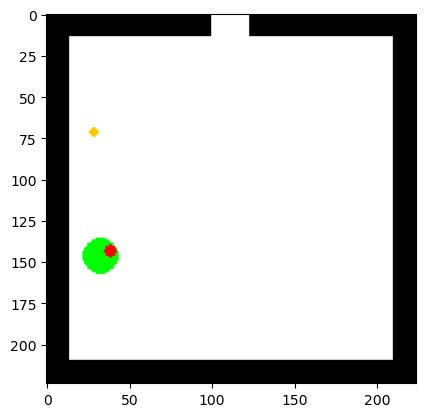

In [46]:
quick_display(target[5])

In [47]:
# ok, no glaring errors. Good.